In [4]:
using Plots, LinearAlgebra, Random
using RandomMatrices, ProgressBars, MatrixEquations
using Convex, SCS, JLD, Gurobi
using MathOptInterface, JuMP
using Mosek, MosekTools
const MOI = MathOptInterface
using KernelEstimator
# const env = Gurobi.Env()

In [5]:
function GD!(nIter, covs, sqrt_covs, X, objective, times, η)
    start = time()
    d = size(covs)[1]
    n = size(covs)[3]
    # Cache variables for memory efficiency. T refers to transport map
    T = zeros(d,d)
    evals = zeros(d)
    evecs = zeros(d,d)
    

    for i in 1:nIter
        T .= zeros(d,d)

        for j in 1:n
            sq = @view sqrt_covs[:,:,j]

            e = eigen(Symmetric(sq*X*sq))
            evals .= e.values
            evecs .= e.vectors
            objective[i] += tr(covs[:,:,j].-2*evecs*diagm(evals.^(0.5))*evecs')

            T .= T .+ sq*evecs*diagm(evals.^(-0.5))*evecs'*sq
        end
        
        objective[i] = objective[i]/n + tr(X)
        
        T .= T./n

        X .= Symmetric(((1 - η).*I(d) .+ η.*T)*X*((1-η).*I(d) + η.*T))
        times[i] = time()-start
    end
end

function EGD!(nIter, covs, sqrt_covs, X, objective, times, η, α, β)
    start = time()
    d = size(covs)[1]
    n = size(covs)[3]
    # Cache variables for memory efficiency. T refers to transport map
    T = zeros(d,d)
    evals = zeros(d)
    evecs = zeros(d,d)
    
    
    for i in 1:nIter
        
        T .= zeros(d,d)

        for j in 1:n
            sq = @view sqrt_covs[:,:,j]
            
            e = eigen(Symmetric(sq*X*sq))
            evals .= e.values
            evecs .= e.vectors
            objective[i] += tr(covs[:,:,j].-2*evecs*diagm(evals.^(0.5))*evecs')

            T .= T .+ sq*evecs*diagm(evals.^(-0.5))*evecs'*sq
        end
    
        objective[i] = objective[i]/n + tr(X)
        times[i] = time()-start
        
        T .= T./n
        X .= Symmetric(X .- η.*(I(d) .- T))
        
        clip!(X, α, β)
    end
end

function SDP!(covs; verbose=false, maxIter = 5000)
    d = size(covs)[1]
    n = size(covs)[3]
    
    Σ = Variable(d,d)
    Ss = [Variable(d,d) for _ in 1:n]
    constr = [([covs[:,:,i] Ss[i]; Ss[i]' Σ] ⪰ 0) for i in 1:n]
    problem = minimize(tr(Σ) - 2*mean(tr.(Ss)))
    problem.constraints += constr
    problem.constraints += (Σ ⪰ 0)
    optimizer = SCS.Optimizer(verbose = verbose)
    MOI.set(optimizer, MOI.RawParameter("max_iters"), maxIter)
    solve!(problem, optimizer)
    return Σ.value
end


# Function that clips eigenvalues of X to specified range, in place
function clip!(X, α, β)
    e = eigen(X)
    X .= e.vectors*diagm(clamp.(e.values, α, β))*e.vectors'
end

# Calculates squared wasserstein distance between two centered Gaussians
function bures(sq,x)
    e = eigen(sq*x*sq)
    return tr(x+sq*sq- 2 .* e.vectors*diagm(e.values.^(.5))*e.vectors')
end

# bary = I(d)
# for i in 1:n
#     A = 0.05*randn(d,d)
#     A = (A + A')/2
#     X = bary + A + lyapc(bary, A)*bary*lyapc(bary, A)
#     covs[:,:,i] .= X
#     e = eigen(X)
#     sqrt_covs[:,:,i] = e.vectors*diagm(e.values.^(0.5))*e.vectors'
# end

function generate_uniform!(covs, sqrt_covs, α, β)
    # Cache variables for memory efficiency
    basis = zeros(d,d)
    evals = zeros(d)
    # Identity matrix for convenience

    for i in 1:n
        # Choose an eigenbasis uniformly at random
        basis .= rand(Haar(1),d)
        # Choose eigenvalues uniformly at random from specified range
        evals .= α .+ (β-α).*rand(d)

        covs[:,:,i] .= Symmetric(basis*diagm(evals)*basis')
        sqrt_covs[:,:,i] .= Symmetric(basis*diagm(sqrt.(evals))*basis')
    end
end 

function barycenter_functional(sqrt_covs, X)
    return mean(bures(sqrt_covs[:,:,i], X) for i in 1:size(sqrt_covs)[3])
end

barycenter_functional (generic function with 1 method)

# Generate and save random dataset

In [239]:
# Number of matrices
n = 30
# Dimension of matrices
d = 30
ID = I(d)
# Minimum and maximum eigenvalues of our matrices
α = 0.005
β = 200
κ = β/α

# covs contains the covariance matrices whose barycenter we are trying to find
covs = zeros(d,d,n)
# sq_covs contains the square roots of the matrices in covs
sqrt_covs = zeros(d,d,n)
generate_uniform!(covs, sqrt_covs, α, β)
save("./data/n$(n)d$(d)a$(α)b$(β).jld", "covs", covs, "sqrt_covs", sqrt_covs)

thresh_a = mean(sqrt(minimum(eigvals(covs[:,:,i]))) for i in 1:n)^2
thresh_b = mean(sqrt(maximum(eigvals(covs[:,:,i]))) for i in 1:n)^2

# Set step sizes
η_gd = 1
η₁ = 100
η₂ = 180
η₃ = 300

300

In [ ]:
# Set up SDP model
Σ = Variable(d,d)
Ss = [Variable(d,d) for _ in 1:n]
constr = [([covs[:,:,i] Ss[i]; Ss[i]' Σ] ⪰ 0) for i in 1:n]
problem = minimize(tr(Σ) - 2*mean(tr.(Ss)))
problem.constraints += constr
problem.constraints += (Σ ⪰ 0)
set_value!(Σ, covs[:,:,7])

solve!(problem, SCS.Optimizer(verbose = false, max_iters = 1), warmstart=true)

In [5]:
for i in 1:n
    if minimum(eigvals(covs[:,:,i])) < 0 || covs[:,:,i] != covs[:,:,i]'
        println("Baj van")
    end
end

### load dataset

In [6]:
loaded = load("./data/n$(n)d$(d)a$(α)b$(β).jld")
covs .= loaded["covs"]
sqrt_covs .= loaded["sqrt_covs"];

# Comparing different algorithms

In [94]:
nIter = 5
nExp = 5
n = 30
d = 30
ID = I(d)
α = 0.005
β = 200
κ = β/α
η_gd = 1
η₁ = 100
η₂ = 180
η₃ = 300

covs = zeros(d,d,n)
sqrt_covs = zeros(d,d,n)

######################
# EGD=1 (η₁)
# EGD=2 (η₂)
# EGD=3 (η₃)
# GD=4
# SDP=5
######################

# Set up arrays
X = zeros(d,d, 4)
X_SDP = zeros(d,d, nIter)
times = zeros(5, nExp, nIter)
objective = zeros(5, nExp, nIter)
optimal_objective = zeros(nExp)

for experiment in 1:nExp
    # Generate new dataset
    generate_uniform!(covs, sqrt_covs, α, β)
    thresh_a = mean(sqrt(minimum(eigvals(covs[:,:,i]))) for i in 1:n)^2
    thresh_b = mean(sqrt(maximum(eigvals(covs[:,:,i]))) for i in 1:n)^2
    
    
    # Compute high precision solution to compare to
    solution = covs[:,:,1]
    GD!(20, covs, sqrt_covs, solution, zeros(20), zeros(20), 1)
    optimal_objective[experiment] = barycenter_functional(sqrt_covs, solution)
    
    # Set up SDP model
    Σ = Variable(d,d)
    Ss = [Variable(d,d) for _ in 1:n]
    constr = [([covs[:,:,i] Ss[i]; Ss[i]' Σ] ⪰ 0) for i in 1:n]
    problem = minimize(tr(Σ) - 2*mean(tr.(Ss)))
    problem.constraints += constr
    problem.constraints += (Σ ⪰ 0)
    
    # Set starting points to be second step of SDP (so everyone starts from same point)
    start = time()
    solve!(problem, SCS.Optimizer(verbose = false, max_iters = 2))
    time_adjust = time() - start

    for i in 1:nIter
        X_SDP[:,:,i] .= Σ.value
    end

    X[:,:, 1] .= Σ.value
    X[:,:, 2] .= Σ.value 
    X[:,:, 3] .= Σ.value
    X[:,:, 4] .= Σ.value
    
    set_value!(Σ, covs[:,:,1])

    tmp_obj = @view objective[1, experiment, :]
    tmp_times = @view times[1, experiment, :]
    tmp_X = @view X[:, :, 1]
    EGD!(nIter, covs, sqrt_covs, tmp_X, tmp_obj, tmp_times, η₁, thresh_a, thresh_b)

    tmp_obj = @view objective[2, experiment, :]
    tmp_times = @view times[2, experiment, :]
    tmp_X = @view X[:, :, 2]
    EGD!(nIter, covs, sqrt_covs, tmp_X, tmp_obj, tmp_times, η₂, thresh_a, thresh_b)

    tmp_obj = @view objective[3, experiment, :]
    tmp_times = @view times[3, experiment, :]
    tmp_X = @view X[:,:, 3]
    EGD!(nIter, covs, sqrt_covs, tmp_X, tmp_obj, tmp_times, η₃, thresh_a, thresh_b)

    tmp_obj = @view objective[4, experiment, :]
    tmp_times = @view times[4, experiment, :]
    tmp_X = @view X[:, :, 4]
    GD!(nIter, covs, sqrt_covs, tmp_X, tmp_obj, tmp_times, η_gd)

    for i in ProgressBar(2:nIter)
        start = time()
        solve!(problem, SCS.Optimizer(verbose = false, max_iters = i+1))
        times[5, experiment, i] = time()-start
        X_SDP[:,:,i] .= Σ.value
    end
    objective[5,experiment, :] = real.([barycenter_functional(sqrt_covs, X_SDP[:,:,i]) for i in 1:nIter]);

    # recenter so that timeseries starts at t=0
    times[1,experiment, :] .= times[1,experiment, :] .- times[1,experiment, 1]
    times[2,experiment, :] .= times[2,experiment, :] .- times[2,experiment, 1]
    times[3,experiment, :] .= times[3,experiment, :] .- times[3,experiment, 1]
    times[4,experiment, :] .= times[4,experiment, :] .- times[4,experiment, 1]
#     times[5,experiment, 2:end] .= max.(0, times[5,experiment, 2:end] .- time_adjust)
end

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253


0.0%┣                                            ┫ 0/4 [00:00<00:00, -20.0 it/s]
25.0%┣██████████▊                                ┫ 1/4 [00:00<Inf:Inf, 0.0 it/s]


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253


50.0%┣██████████████████████▌                      ┫ 2/4 [00:01<00:01, 1.7 it/s]


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253


75.0%┣█████████████████████████████████▊           ┫ 3/4 [00:01<00:00, 2.3 it/s]


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253


100.0%┣████████████████████████████████████████████┫ 4/4 [00:01<00:00, 2.5 it/s]
100.0%┣████████████████████████████████████████████┫ 4/4 [00:01<00:00, 2.5 it/s]



┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253


0.0%┣                                            ┫ 0/4 [00:00<00:00, -20.0 it/s]
25.0%┣██████████▊                                ┫ 1/4 [00:00<Inf:Inf, 0.0 it/s]


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253


50.0%┣██████████████████████▌                      ┫ 2/4 [00:01<00:01, 1.8 it/s]


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253


75.0%┣█████████████████████████████████▊           ┫ 3/4 [00:01<00:00, 2.1 it/s]


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253


100.0%┣████████████████████████████████████████████┫ 4/4 [00:01<00:00, 2.3 it/s]
100.0%┣████████████████████████████████████████████┫ 4/4 [00:01<00:00, 2.3 it/s]



┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253


0.0%┣                                            ┫ 0/4 [00:00<00:00, -20.0 it/s]
25.0%┣██████████▊                                ┫ 1/4 [00:00<Inf:Inf, 0.0 it/s]


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253


50.0%┣██████████████████████▌                      ┫ 2/4 [00:01<00:01, 1.9 it/s]


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253


75.0%┣█████████████████████████████████▊           ┫ 3/4 [00:01<00:00, 2.4 it/s]


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253


100.0%┣████████████████████████████████████████████┫ 4/4 [00:01<00:00, 2.5 it/s]
100.0%┣████████████████████████████████████████████┫ 4/4 [00:01<00:00, 2.5 it/s]



┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253


0.0%┣                                            ┫ 0/4 [00:00<00:00, -20.0 it/s]
25.0%┣██████████▊                                ┫ 1/4 [00:00<Inf:Inf, 0.0 it/s]


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253


50.0%┣██████████████████████▌                      ┫ 2/4 [00:01<00:01, 1.8 it/s]


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253


75.0%┣█████████████████████████████████▊           ┫ 3/4 [00:01<00:00, 2.4 it/s]


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253


100.0%┣████████████████████████████████████████████┫ 4/4 [00:01<00:00, 2.6 it/s]
100.0%┣████████████████████████████████████████████┫ 4/4 [00:01<00:00, 2.6 it/s]



┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253


0.0%┣                                            ┫ 0/4 [00:00<00:00, -20.0 it/s]
25.0%┣██████████▊                                ┫ 1/4 [00:00<Inf:Inf, 0.0 it/s]


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253


50.0%┣██████████████████████▌                      ┫ 2/4 [00:01<00:01, 1.9 it/s]


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253


75.0%┣█████████████████████████████████▊           ┫ 3/4 [00:01<00:00, 2.4 it/s]


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253


100.0%┣████████████████████████████████████████████┫ 4/4 [00:01<00:00, 2.6 it/s]
100.0%┣████████████████████████████████████████████┫ 4/4 [00:01<00:00, 2.6 it/s]



┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/patrik/.julia/packages/Convex/tMJiC/src/solution.jl:253


In [95]:
log_objective = log.(objective .- optimal_objective');
collated = zeros(5, nIter*nExp, 2)
for algo in 1:5
    collated[algo, :, :] = [reshape(times[algo, :, :], (nIter*nExp,)) reshape(log_objective[algo, :, :], (nIter*nExp,))]
    
    collated[algo, :, :] .= sortslices(collated[algo, :, :], dims=1, lt=(x,y)->isless(x[1],y[1]))
end

smoothed = zeros(5, nIter*nExp)
for algo in 1:5
    smoothed[algo, :] = KernelEstimator.npr(collated[algo, :, 1], collated[algo, :, 2], kernel=gaussiankernel, reg=localconstant)
end

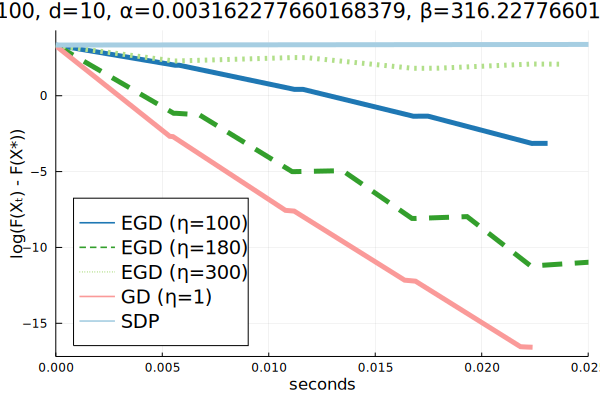

In [253]:
plot(collated[:,:,1]', smoothed', 
    linestyles = [:solid :dash :dot :solid :solid], 
    linecolors = [2 4 3 5 1], 
    linewidth = 5, 
    labels=["EGD (η=$(η₁))" "EGD (η=$(η₂))" "EGD (η=$(η₃))" "GD (η=1)" "SDP"], 
    legend=:bottomleft, 
    legendfontsize=13, 
    color_palette=palette(:Paired_5, 5), 
    fontfamily = "New Century Schoolbook Roman")
title!("n=$(n), d=$(d), α=$(α), β=$(β)")
ylabel!("log(F(Xₜ) - F(X*))")
xlabel!("seconds")
xlims!(0,0.025)
# ylims!()

# Dependence on condition number

### Generate random dataset

In [222]:
# Number of matrices
n = 100
# Dimension of matrices
d = 10
ID = I(d)

# covs contains the covariance matrices whose barycenter we are trying to find
covs = zeros(d,d,n)
# sq_covs contains the square roots of the matrices in covs
sqrt_covs = zeros(d,d,n)

nIter = 40
η_gd = 1
η₁ = 100
η₂ = 180
η₃ = 300

######################
# EGD=1 (η₁)
# EGD=2 (η₂)
# EGD=3 (η₃)
# GD=4
######################

# values of κ to compare
κs = LinRange(2,100000,10)

# Set up arrays
X = zeros(d, d)
objective = zeros(nIter, length(κs), 4)
times = zeros(nIter, length(κs), 4)
best = zeros(length(κs))

for i in 1:length(κs)
    κ = κs[i]
    α = 1/sqrt(κ)
    β = sqrt(κ)
    generate_uniform!(covs, sqrt_covs, α, β)

    thresh_a = mean(sqrt(minimum(eigvals(covs[:,:,i]))) for i in 1:n)^2
    thresh_b = mean(sqrt(maximum(eigvals(covs[:,:,i]))) for i in 1:n)^2
    
    X .= covs[:,:,1]
    obj_tmp = @view objective[:,i, 1]
    times_tmp = @view times[:,i, 1]
    EGD!(nIter, covs, sqrt_covs, X, obj_tmp, times_tmp, η₁, thresh_a, thresh_b)
    
    X .= covs[:,:,1]
    obj_tmp = @view objective[:,i, 2]
    times_tmp = @view times[:,i, 2]
    EGD!(nIter, covs, sqrt_covs, X, obj_tmp, times_tmp, η₂, thresh_a, thresh_b)
    
    X .= covs[:,:,1]
    obj_tmp = @view objective[:,i, 3]
    times_tmp = @view times[:,i, 3]
    EGD!(nIter, covs, sqrt_covs, X, obj_tmp, times_tmp, η₃, thresh_a, thresh_b)
    
    X .= covs[:,:,1]
    obj_tmp = @view objective[:,i, 4]
    times_tmp = @view times[:,i, 4]
    GD!(nIter, covs, sqrt_covs, X, obj_tmp, times_tmp, η_gd)
    
    # Set output of GD! as benchmark   
    best[i] = minimum(objective[:,i,:])
end

In [223]:
ϵ = -10
first_index = Array{Int64}(undef, (length(κs), 4))
for model in 1:4
    arr = log10.(objective[:, :, model] .- best')
    for κ in 1:length(κs)
        first_index[κ, model] = nIter
        done=false
        for j in 1:nIter
            if arr[j,κ] < ϵ
                done = true
                first_index[κ, model] = min(first_index[κ, model], j)
            end
        end
        if !done
            first_index[κ, model] = 1000
        end
    end
end

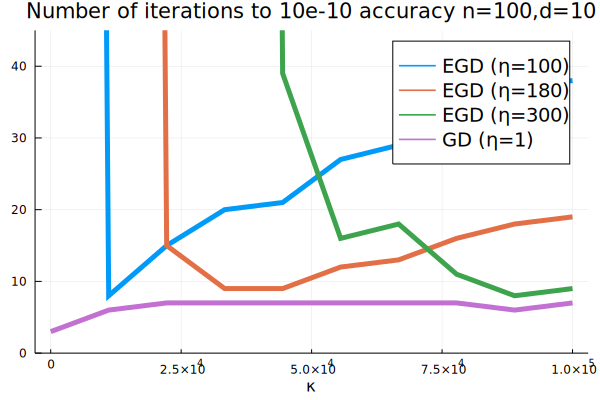

In [250]:
plot(κs, first_index, 
    labels=["EGD (η=$(η₁))" "EGD (η=$(η₂))" "EGD (η=$(η₃))" "GD (η=1)" "SDP"],
    legend=:topright,
    legendfontsize=13,
    linewidth = 5, 
    fontfamily = "New Century Schoolbook Roman")
title!("Number of iterations to 10e$(ϵ) accuracy n=$(n),d=$(d)")
ylims!(0,45)
xlabel!("κ")

# Dependence on dimension

In [255]:
# Number of matrices
n = 30
α = 0.1
β = 10


nIter = 10
η_gd = 1
η₁ = 8
η₂ = 9
η₃ = 10

######################
# EGD=1 (η₁)
# EGD=2 (η₂)
# EGD=3 (η₃)
# GD=4
######################

# values of κ to compare
ds = [2,3,5,10,20,30,40,50,70,90,100,130,150,180, 200]

# Set up arrays
objective = zeros(nIter, length(ds), 4)
times = zeros(nIter, length(ds), 4)
best = zeros(length(ds))

for i in 1:length(ds)
    d = ds[i]
    
    # covs contains the covariance matrices whose barycenter we are trying to find
    covs = zeros(d,d,n)
    # sq_covs contains the square roots of the matrices in covs
    sqrt_covs = zeros(d,d,n)
    
    X = zeros(d, d)

    generate_uniform!(covs, sqrt_covs, α, β)

    thresh_a = mean(sqrt(minimum(eigvals(covs[:,:,i]))) for i in 1:n)^2
    thresh_b = mean(sqrt(maximum(eigvals(covs[:,:,i]))) for i in 1:n)^2
    
    X .= covs[:,:,1]
    obj_tmp = @view objective[:,i, 1]
    times_tmp = @view times[:,i, 1]
    EGD!(nIter, covs, sqrt_covs, X, obj_tmp, times_tmp, η₁, thresh_a, thresh_b)
    
    X .= covs[:,:,1]
    obj_tmp = @view objective[:,i, 2]
    times_tmp = @view times[:,i, 2]
    EGD!(nIter, covs, sqrt_covs, X, obj_tmp, times_tmp, η₂, thresh_a, thresh_b)
    
    X .= covs[:,:,1]
    obj_tmp = @view objective[:,i, 3]
    times_tmp = @view times[:,i, 3]
    EGD!(nIter, covs, sqrt_covs, X, obj_tmp, times_tmp, η₃, thresh_a, thresh_b)
    
    X .= covs[:,:,1]
    obj_tmp = @view objective[:,i, 4]
    times_tmp = @view times[:,i, 4]
    GD!(nIter, covs, sqrt_covs, X, obj_tmp, times_tmp, η_gd)
    
    # Set output of GD! as benchmark   
    best[i] = minimum(objective[:,i,:])
end

In [256]:
ϵ = -7
first_index = Array{Int64}(undef, (length(ds), 4))
for model in 1:4
    arr = log10.(objective[:, :, model] .- best')
    for d in 1:length(ds)
        first_index[d, model] = nIter
        done=false
        for j in 1:nIter
            if arr[j,d] < ϵ
                done = true
                first_index[d, model] = min(first_index[d, model], j)
            end
        end
        if !done
            first_index[d, model] = 1000
        end
    end
end

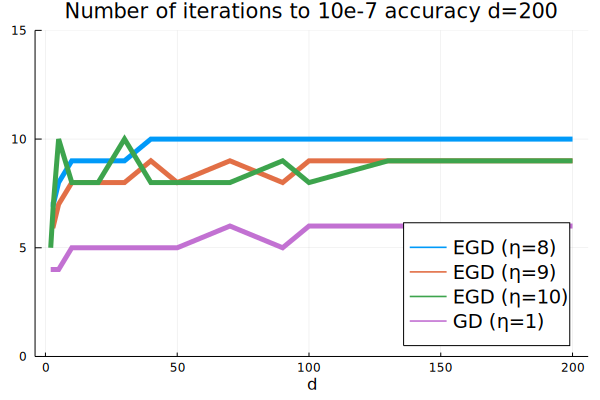

In [257]:
plot(ds, first_index, 
    labels=["EGD (η=$(η₁))" "EGD (η=$(η₂))" "EGD (η=$(η₃))" "GD (η=1)" "SDP"], 
    legend=:bottomright,
    legendfontsize=13,
    linewidth = 5, 
    fontfamily = "New Century Schoolbook Roman")
title!("Number of iterations to 10e$(ϵ) accuracy d=$(d)")
ylims!(0,15)
xlabel!("d")

# Trying MOSEK instead of SCS (slower)


In [371]:
model = Model(Mosek.Optimizer)
@variable(model, Σ[1:d,1:d], PSD)
Ss = []
for i in 1:n
    push!(Ss, @variable(model, [1:d,1:d], Symmetric))
end

for i in 1:n
    @SDconstraint(model, [covs[:,:,i] Ss[i]; Ss[i]' Σ] >= 0)
#     @SDconstraint(model, Σ - Ss[i]*covs[:,:,i]^(-1)*Ss[i]' >= 0)
#     @constraint(model, Σ - Ss[i]*covs[:,:,i]^(-1)*Ss[i]' in PSDCone())
end
@objective(model, Min, tr(Σ)-2*mean(tr(Ss[i]) for i in 1:n));
@time optimize!(model)
value.(Σ)

1000-element LinRange{Float64}:
 2.0,12.008,22.016,32.024,42.032,52.04,…,9969.98,9979.98,9989.99,10000.0